##Task 1 - Set up project environment

Installing needed modules

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.7/767.7 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 0.28.1
    Uninstalling openai-0.28.1:
      Successfully uninstalled openai-0.28.1


Importing the needed modules and setup the OpenAI API

In [ ]:
import pandas as pd
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv
import os

from sklearn.metrics.pairwise import cosine_similarity

# Loading API key and organization ID from a dotenv file
load_dotenv(dotenv_path='/content/drive/MyDrive/Colab Notebooks/Data Scenarios/#1: E-Commerce Product /.env')

# Retrieving API key and organization ID from environment variables
APIKEY = os.getenv("APIKEY")
ORGID = os.getenv("ORGID")

# Creating an instance of the OpenAI client with the provided API key and organization ID
client = OpenAI(
    api_key=APIKEY,
    organization=ORGID
)


##Task 2 - Prepare the Knowledge Base
In this task, we will load the product dataset and review its contents. W e will then generate the text embedding vectors required for our RAG system


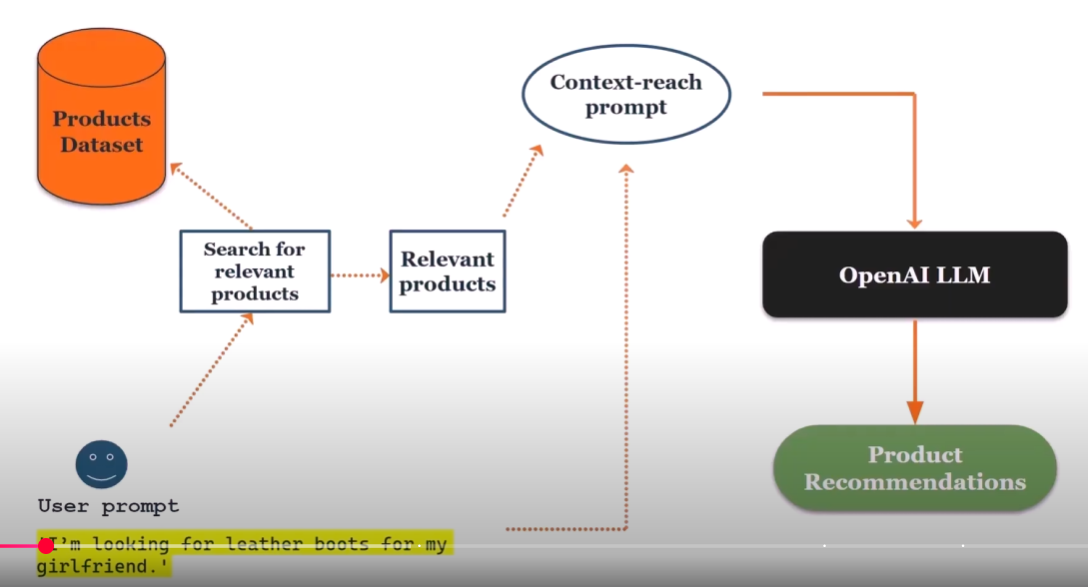

**Loading the products dataset**

In [ ]:
products_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Scenarios/#1: E-Commerce Product /products_dataset.csv")
products_data

,product_id,title,description
0,P0,Men's 3X Large Carbon Heather Cotton/Polyester...,"This heavyweight, water-repellent hooded sweat..."
1,P1,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,If you need more length between your existing ...
2,P2,Large Tapestry Bolster Bed,Polyester cover resembling rich Italian tapest...
3,P3,16-Gauge-Sinks Vessel Sink in White with Faucet,It features a rectangle shape. This vessel set...
4,P4,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,This 9 in. black full grain leather logger boo...
...,...,...,...
1995,P1995,Dotty Black and White Black and White Wallpape...,"With a stylish monochrome look, this dotty wal..."
1996,P1996,Abrielle Brown/Light Gray 8 ft. x 10 ft. Orien...,The Abrielle collection features a stunning as...
1997,P1997,20 in. x 2-1/2 in. x 2-1/2 in. Polyurethane As...,"With Fypon balustrade systems, you can transfo..."
1998,P1998,1 gal. #P120-6 Diva Glam Flat Exterior Paint &...,BEHR PREMIUM PLUS Exterior Paint & Primer is a...


In [ ]:
# I want to create a text embedding vector for each of the products that we have.
# Before I do this, I want to combine product title and product description column to include more info about each product within our text embedding vectors.


**Combining product title and description**

In [ ]:
products_data["item"] = products_data["title"] + products_data["description"]
products_data

,product_id,title,description,item
0,P0,Men's 3X Large Carbon Heather Cotton/Polyester...,"This heavyweight, water-repellent hooded sweat...",Men's 3X Large Carbon Heather Cotton/Polyester...
1,P1,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,If you need more length between your existing ...,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...
2,P2,Large Tapestry Bolster Bed,Polyester cover resembling rich Italian tapest...,Large Tapestry Bolster BedPolyester cover rese...
3,P3,16-Gauge-Sinks Vessel Sink in White with Faucet,It features a rectangle shape. This vessel set...,16-Gauge-Sinks Vessel Sink in White with Fauce...
4,P4,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,This 9 in. black full grain leather logger boo...,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...
...,...,...,...,...
1995,P1995,Dotty Black and White Black and White Wallpape...,"With a stylish monochrome look, this dotty wal...",Dotty Black and White Black and White Wallpape...
1996,P1996,Abrielle Brown/Light Gray 8 ft. x 10 ft. Orien...,The Abrielle collection features a stunning as...,Abrielle Brown/Light Gray 8 ft. x 10 ft. Orien...
1997,P1997,20 in. x 2-1/2 in. x 2-1/2 in. Polyurethane As...,"With Fypon balustrade systems, you can transfo...",20 in. x 2-1/2 in. x 2-1/2 in. Polyurethane As...
1998,P1998,1 gal. #P120-6 Diva Glam Flat Exterior Paint &...,BEHR PREMIUM PLUS Exterior Paint & Primer is a...,1 gal. #P120-6 Diva Glam Flat Exterior Paint &...


**Create the text embedding vectors**

In [ ]:
# we need to use OpenAI text embedding models
# text embedding models are a type of naturel language processing technique used to represent words, phrases or entire documents as numerical vectors in a high-dimensional space.

# basically text embedding model gets a piece of text and converted into a vector of numerical values.
# these vectors capture the contextual meaning of the text

if you have two sentences and you want to know how similar they are in terms of the meaning, you can use the text embedding model to convert these two texts into numerical vectors and by comparing these numerical vector.
You can have an understanding of how similar or how different these two sentences are.

In [13]:
'''
client.embeddings.create(
    model="text-embedding-3-small",
    input = ["apple"], # list of the text that I want to generate the text embedding for
    dimensions = 3 # no of dimensions of the generated text embedding vectors
    # it means that as this value(3) gets higher that means that it includes more info about the word "apple"
    # but its gonna get expensive sure.
)
'''

CreateEmbeddingResponse(data=[Embedding(embedding=[0.3642943501472473, -0.3472922742366791, -0.8641051650047302], index=0, object='embedding')], model='text-embedding-3-small', object='list', usage=Usage(prompt_tokens=1, total_tokens=1))

CreateEmbeddingResponse(data=[Embedding(embedding=[0.3642943501472473, -0.3472922742366791, -0.8641051650047302], index=0, object='embedding')], model='text-embedding-3-small', object='list', usage=Usage(prompt_tokens=1, total_tokens=1))

***Meaning of this:***
* One embedding object, within this 3 embedding vector. Containing 3 dimensions describing the word apple.

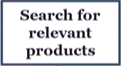



In [14]:
response = client.embeddings.create(
    model = "text-embedding-3-small",
    input = products_data.item.to_list(),
    dimensions = 512 #each of the products that we have is going to be described by 512 numerical values.
)

# want to loop through the data property and find all of the embedding vectors in the response
# using list comprehension
vector_embeddings = [d.embedding for d in response.data] # go to response's data grab the list and start looping through for each item I return this embedding parameter in the result
products_data["embedding vector"] = vector_embeddings
products_data

,product_id,title,description,item,embedding vector
0,P0,Men's 3X Large Carbon Heather Cotton/Polyester...,"This heavyweight, water-repellent hooded sweat...",Men's 3X Large Carbon Heather Cotton/Polyester...,"[0.03744583949446678, 0.03042474389076233, -0...."
1,P1,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,If you need more length between your existing ...,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,"[0.03523961082100868, 0.013278326019644737, 0...."
2,P2,Large Tapestry Bolster Bed,Polyester cover resembling rich Italian tapest...,Large Tapestry Bolster BedPolyester cover rese...,"[0.035860564559698105, -0.05905349925160408, 0..."
3,P3,16-Gauge-Sinks Vessel Sink in White with Faucet,It features a rectangle shape. This vessel set...,16-Gauge-Sinks Vessel Sink in White with Fauce...,"[-0.05834035575389862, -0.007969953119754791, ..."
4,P4,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,This 9 in. black full grain leather logger boo...,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,"[0.01998496614396572, 0.05075598508119583, -0...."
...,...,...,...,...,...
1995,P1995,Dotty Black and White Black and White Wallpape...,"With a stylish monochrome look, this dotty wal...",Dotty Black and White Black and White Wallpape...,"[0.0883023664355278, -0.05272488296031952, -0...."
1996,P1996,Abrielle Brown/Light Gray 8 ft. x 10 ft. Orien...,The Abrielle collection features a stunning as...,Abrielle Brown/Light Gray 8 ft. x 10 ft. Orien...,"[0.010993942618370056, -0.040396347641944885, ..."
1997,P1997,20 in. x 2-1/2 in. x 2-1/2 in. Polyurethane As...,"With Fypon balustrade systems, you can transfo...",20 in. x 2-1/2 in. x 2-1/2 in. Polyurethane As...,"[-0.034120045602321625, -0.009548034518957138,..."
1998,P1998,1 gal. #P120-6 Diva Glam Flat Exterior Paint &...,BEHR PREMIUM PLUS Exterior Paint & Primer is a...,1 gal. #P120-6 Diva Glam Flat Exterior Paint &...,"[-0.010861445218324661, -0.014231621287763119,..."


## Task 3 - Retrieve relevant items based on user prompts

In this task, we will use the embedding vectors to retrieve relevant items based on the user's search phrase.

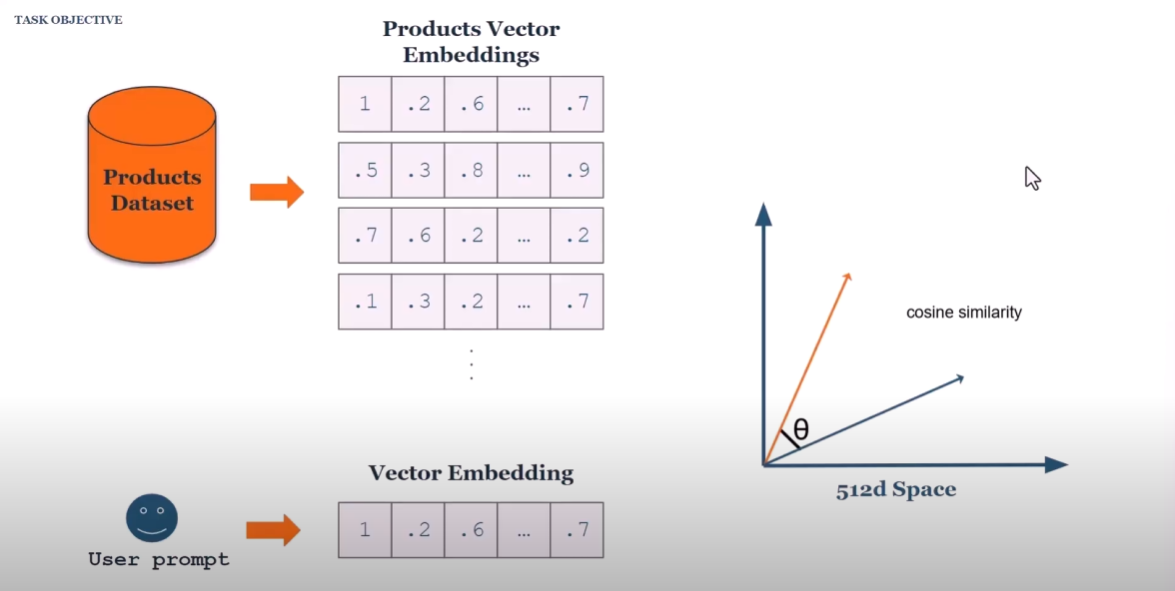

In [15]:
user_prompt = "I'm remodeling my bathroom and need a stylish white sink with a faucet included."

**Lets find the embedding vector of the user prompt.**

In [16]:
response = client.embeddings.create(
    input=user_prompt,
    model="text-embedding-3-small",
    dimensions = 512
)
user_prompt_vector = [d.embedding for d in response.data]
print(user_prompt_vector[:10])

[[-0.041442643851041794, -0.025813423097133636, -0.0494421161711216, -0.052769627422094345, -0.04413154348731041, -0.0335271991789341, -0.005604672245681286, 0.0611388236284256, -0.02996440976858139, -0.05794575810432434, -0.007612943183630705, 0.018855899572372437, -0.039089858531951904, -0.028300654143095016, 0.0287207942456007, 0.08745641261339188, 0.00044639912084676325, -0.07347414642572403, -0.02835107035934925, 0.08019638806581497, -0.031039968132972717, 0.026922592893242836, -0.03339275345206261, -0.06591162085533142, 0.02623356319963932, 0.01641068235039711, -0.04497182369232178, -0.0061802645213902, -0.026048701256513596, 0.0017131222411990166, -0.031762611120939255, -0.03818235546350479, -0.04429959878325462, 0.006155055947601795, -0.008125514723360538, 0.04537515714764595, 0.003630012506619096, -0.025158004835247993, 0.041946813464164734, -0.02263716235756874, -0.03791346400976181, 0.08248195052146912, 0.04063597321510315, -0.0008071946213021874, 0.04117375239729881, 0.0135

**Find similar products to the user prommpt.**

==> cosine similarity
calculates the angle between two vectors. the smaller the angel the more similar the vectors are.

-this is especially useful in high-dimensional spaces because it focuses on the direction of the vectors rather then their magnitude.

-cosine similar is ideal because we are interested in the semantic similarity between the users prompt and dataset entries regardless of their absolute values or lengths, cosine similarity helps us capture that meaning effectively.

In [21]:
products_data["embedding vector"]
# 2000 different products I have, now:
# we need to convert each of these embedding vectors into a numpy array,
# the reason is that the cosine similarity from sklearn only accepts numpy arrays

,embedding vector
0,"[0.03744583949446678, 0.03042474389076233, -0...."
1,"[0.03523961082100868, 0.013278326019644737, 0...."
2,"[0.035860564559698105, -0.05905349925160408, 0..."
3,"[-0.05834035575389862, -0.007969953119754791, ..."
4,"[0.01998496614396572, 0.05075598508119583, -0...."
...,...
1995,"[0.0883023664355278, -0.05272488296031952, -0...."
1996,"[0.010993942618370056, -0.040396347641944885, ..."
1997,"[-0.034120045602321625, -0.009548034518957138,..."
1998,"[-0.010861445218324661, -0.014231621287763119,..."


In [22]:
products_data["embedding vector"].values
# this'll return a list of lists that each lists is basically our embedding vectors

array([list([0.03744583949446678, 0.03042474389076233, -0.01368488185107708, -0.0015062749153003097, 0.007485594600439072, -0.03556997328996658, 0.021420592442154884, 0.08196637034416199, 0.049129799008369446, -0.05770518258213997, 0.04198364540934563, 0.04251960664987564, -0.058669913560152054, 0.03108576312661171, 0.02281409129500389, 0.06456548720598221, 0.10433382540941238, -0.03744583949446678, -0.0877547562122345, 0.06442256271839142, -0.05638314411044121, 0.05841979756951332, -0.02667301520705223, -0.07710698992013931, 0.026279976591467857, 0.03805326297879219, -0.04812933877110481, 0.03258645534515381, 0.055668529123067856, -0.01590018905699253, 0.003582008881494403, -0.023582303896546364, 0.01852640137076378, -0.026083456352353096, 0.04416322335600853, -0.0707111805677414, -0.021527783945202827, 0.10947905480861664, -0.033837031573057175, 0.028566744178533554, 0.031246552243828773, -0.057490795850753784, 0.01401539146900177, -0.05934879556298256, 0.026833802461624146, 0.037017

In [29]:
# I am going to cut this I can define a list comprehension
product_vectors = [np.array(vec) for vec in products_data["embedding vector"]]
# now the text embeddings are converted into numpy array
# do the same thing with user prompt
user_prompt_vector = np.array(user_prompt_vector)

similarity_matrix = cosine_similarity(product_vectors, user_prompt_vector)
similarity_values = [v[0] for v in similarity_matrix]
similarity_values[:10]

[np.float64(0.15474202649439375),
 np.float64(0.1587400742458947),
 np.float64(0.19831095342612168),
 np.float64(0.5866690186740093),
 np.float64(0.17582810209521416),
 np.float64(0.18178311739400713),
 np.float64(0.266827034636402),
 np.float64(0.19755377471384822),
 np.float64(0.21688862351291305),
 np.float64(0.36925156779987217)]

In [30]:
len(similarity_values)

2000

In [31]:
products_data["similarity_measure"] = similarity_values
products_data

,product_id,title,description,item,embedding vector,similarity_measure
0,P0,Men's 3X Large Carbon Heather Cotton/Polyester...,"This heavyweight, water-repellent hooded sweat...",Men's 3X Large Carbon Heather Cotton/Polyester...,"[0.03744583949446678, 0.03042474389076233, -0....",0.154742
1,P1,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,If you need more length between your existing ...,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,"[0.03523961082100868, 0.013278326019644737, 0....",0.158740
2,P2,Large Tapestry Bolster Bed,Polyester cover resembling rich Italian tapest...,Large Tapestry Bolster BedPolyester cover rese...,"[0.035860564559698105, -0.05905349925160408, 0...",0.198311
3,P3,16-Gauge-Sinks Vessel Sink in White with Faucet,It features a rectangle shape. This vessel set...,16-Gauge-Sinks Vessel Sink in White with Fauce...,"[-0.05834035575389862, -0.007969953119754791, ...",0.586669
4,P4,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,This 9 in. black full grain leather logger boo...,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,"[0.01998496614396572, 0.05075598508119583, -0....",0.175828
...,...,...,...,...,...,...
1995,P1995,Dotty Black and White Black and White Wallpape...,"With a stylish monochrome look, this dotty wal...",Dotty Black and White Black and White Wallpape...,"[0.0883023664355278, -0.05272488296031952, -0....",0.339013
1996,P1996,Abrielle Brown/Light Gray 8 ft. x 10 ft. Orien...,The Abrielle collection features a stunning as...,Abrielle Brown/Light Gray 8 ft. x 10 ft. Orien...,"[0.010993942618370056, -0.040396347641944885, ...",0.259510
1997,P1997,20 in. x 2-1/2 in. x 2-1/2 in. Polyurethane As...,"With Fypon balustrade systems, you can transfo...",20 in. x 2-1/2 in. x 2-1/2 in. Polyurethane As...,"[-0.034120045602321625, -0.009548034518957138,...",0.251777
1998,P1998,1 gal. #P120-6 Diva Glam Flat Exterior Paint &...,BEHR PREMIUM PLUS Exterior Paint & Primer is a...,1 gal. #P120-6 Diva Glam Flat Exterior Paint &...,"[-0.010861445218324661, -0.014231621287763119,...",0.257193


In [33]:
products_data.sort_values("similarity_measure", ascending=False, inplace=True)
products_data

,product_id,title,description,item,embedding vector,similarity_measure
946,P946,Cantrio Oval Drop-In Bathroom Sink in White,This Vitreous China round bathroom sink by Can...,Cantrio Oval Drop-In Bathroom Sink in WhiteThi...,"[-0.03304377570748329, -0.012316795065999031, ...",0.592571
1665,P1665,Single Hole Single-Handle Bathroom Faucet in O...,"Charming and simplistic,This Waterfall Bathroo...",Single Hole Single-Handle Bathroom Faucet in O...,"[-0.04093712940812111, 0.041281141340732574, -...",0.587538
3,P3,16-Gauge-Sinks Vessel Sink in White with Faucet,It features a rectangle shape. This vessel set...,16-Gauge-Sinks Vessel Sink in White with Fauce...,"[-0.05834035575389862, -0.007969953119754791, ...",0.586669
1638,P1638,Glass Vessel Sink in Smoky Black with Waterfal...,This flower petal formed vessel features grace...,Glass Vessel Sink in Smoky Black with Waterfal...,"[-0.0013510264689102769, 0.04279814660549164, ...",0.574552
983,P983,Decorum Vitreous China Wall-Hung Rectangle Ves...,The Decorum Wall-Hung Bathroom Sink from Ameri...,Decorum Vitreous China Wall-Hung Rectangle Ves...,"[-0.009413822554051876, -0.015025733970105648,...",0.571173
...,...,...,...,...,...,...
181,P181,6-Zone Talkback Page Control with Power,The VC-V-2006AHF is a telephone-compatible si ...,6-Zone Talkback Page Control with PowerThe VC-...,"[0.02312960848212242, -0.018294284120202065, 0...",0.054652
1514,P1514,Engine Cooling Fan Motor,Our products are engineered and tested to prov...,Engine Cooling Fan MotorOur products are engin...,"[0.025743359699845314, 0.017624834552407265, 0...",0.054286
374,P374,Cover for Lawn-Boy Walk-Behind Mowers,Protect your investment with this Lawn-Boy Wal...,Cover for Lawn-Boy Walk-Behind MowersProtect y...,"[0.0669979527592659, 0.042813491076231, -0.047...",0.051026
1949,P1949,Universal Joint - Rear Shaft All Joints,GMB is one of the largest global manufacturers...,Universal Joint - Rear Shaft All JointsGMB is ...,"[-0.03969670087099075, 0.07630717009305954, 0....",0.040910


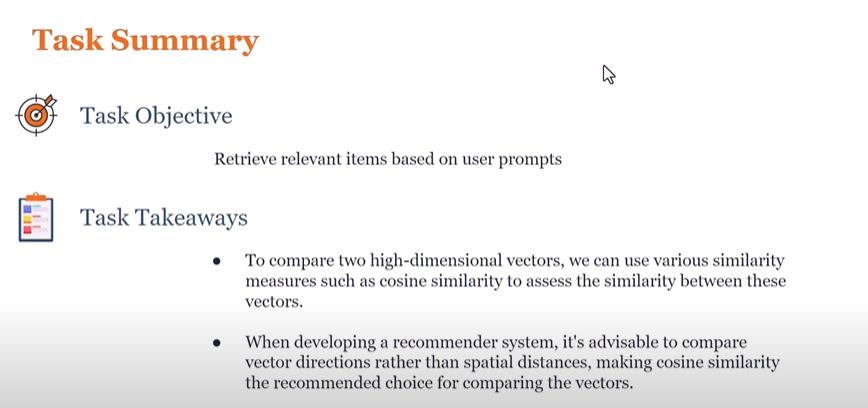

## Task 4 - Craft the context-reach prompt

In this task, we use the retrieved products to craft a context-rich prompt for our LLM request.

**Getting the top-10 similar items**

In [34]:
top_10_items = products_data.head(10)
top_10_items

,product_id,title,description,item,embedding vector,similarity_measure
946,P946,Cantrio Oval Drop-In Bathroom Sink in White,This Vitreous China round bathroom sink by Can...,Cantrio Oval Drop-In Bathroom Sink in WhiteThi...,"[-0.03304377570748329, -0.012316795065999031, ...",0.592571
1665,P1665,Single Hole Single-Handle Bathroom Faucet in O...,"Charming and simplistic,This Waterfall Bathroo...",Single Hole Single-Handle Bathroom Faucet in O...,"[-0.04093712940812111, 0.041281141340732574, -...",0.587538
3,P3,16-Gauge-Sinks Vessel Sink in White with Faucet,It features a rectangle shape. This vessel set...,16-Gauge-Sinks Vessel Sink in White with Fauce...,"[-0.05834035575389862, -0.007969953119754791, ...",0.586669
1638,P1638,Glass Vessel Sink in Smoky Black with Waterfal...,This flower petal formed vessel features grace...,Glass Vessel Sink in Smoky Black with Waterfal...,"[-0.0013510264689102769, 0.04279814660549164, ...",0.574552
983,P983,Decorum Vitreous China Wall-Hung Rectangle Ves...,The Decorum Wall-Hung Bathroom Sink from Ameri...,Decorum Vitreous China Wall-Hung Rectangle Ves...,"[-0.009413822554051876, -0.015025733970105648,...",0.571173
79,P79,24.38 in. x 14 in. x 6 in. White Above Counter...,Bathroom vessel sinks make the bathroom look m...,24.38 in. x 14 in. x 6 in. White Above Counter...,"[-0.0011324023362249136, 0.0246982891112566, 0...",0.561791
780,P780,25.6 in. W x 15.7 in. D x 11.8 in. H Vanity in...,If you are looking for a high-end basin design...,25.6 in. W x 15.7 in. D x 11.8 in. H Vanity in...,"[-0.013936884701251984, 0.023608746007084846, ...",0.559597
347,P347,Modern in White Ceramic Rectangular Vessel Sin...,It features a rectangle shape. This vessel set...,Modern in White Ceramic Rectangular Vessel Sin...,"[-0.038145989179611206, -0.038689106702804565,...",0.556778
1013,P1013,Porcelain Vessel Sink in Bisque with 718 Fauce...,This square format basin's sides taper outward...,Porcelain Vessel Sink in Bisque with 718 Fauce...,"[-0.044103436172008514, 0.011328606866300106, ...",0.555145
1423,P1423,Miranda 59.5 in. W Double Bath Vanity in White...,Sleek and chic are the best words to describe ...,Miranda 59.5 in. W Double Bath Vanity in White...,"[-0.03679736703634262, 0.030826933681964874, 0...",0.553559


**Let's combine the information about all the related products.**

In [35]:
combined_text = "\n\n".join(top_10_items["item"])
combined_text

"Cantrio Oval Drop-In Bathroom Sink in WhiteThis Vitreous China round bathroom sink by Cantrio is the epitome of modern style. This refined statement piece is ideal for a faucet mount of your choosing and is equipped with a pre-drilled center drain. The stain resistant vitreous surface and unparalleled design make this drop-in sink both practical and sophisticated.\n\nSingle Hole Single-Handle Bathroom Faucet in Oil Rubbed BronzeCharming and simplistic,This Waterfall Bathroom Sink Faucet is a brilliant accessory for your bathroom.It always uses the best material to bring the best guarantee and quality to our customers.The faucet's low lead solid brass fabricated body ensures the service life of faucet and best water experience for customers.It is available in multiple finishes and is perfect for bathrooms with contemporary and farmhouse styles.\n\n16-Gauge-Sinks Vessel Sink in White with FaucetIt features a rectangle shape. This vessel set is designed to be installed as a undermount ve

**Now lets craft our prompt**

In [36]:
prompt = f"""
I want you to act as a customer service agent. We have the following products:
{combined_text}

based on the user prompt and the products listed above, please provide two products as recommendations.
here is the user prompt {user_prompt}
"""
print(prompt)


I want you to act as a customer service agent. We have the following products:
Cantrio Oval Drop-In Bathroom Sink in WhiteThis Vitreous China round bathroom sink by Cantrio is the epitome of modern style. This refined statement piece is ideal for a faucet mount of your choosing and is equipped with a pre-drilled center drain. The stain resistant vitreous surface and unparalleled design make this drop-in sink both practical and sophisticated.

Single Hole Single-Handle Bathroom Faucet in Oil Rubbed BronzeCharming and simplistic,This Waterfall Bathroom Sink Faucet is a brilliant accessory for your bathroom.It always uses the best material to bring the best guarantee and quality to our customers.The faucet's low lead solid brass fabricated body ensures the service life of faucet and best water experience for customers.It is available in multiple finishes and is perfect for bathrooms with contemporary and farmhouse styles.

16-Gauge-Sinks Vessel Sink in White with FaucetIt features a rect

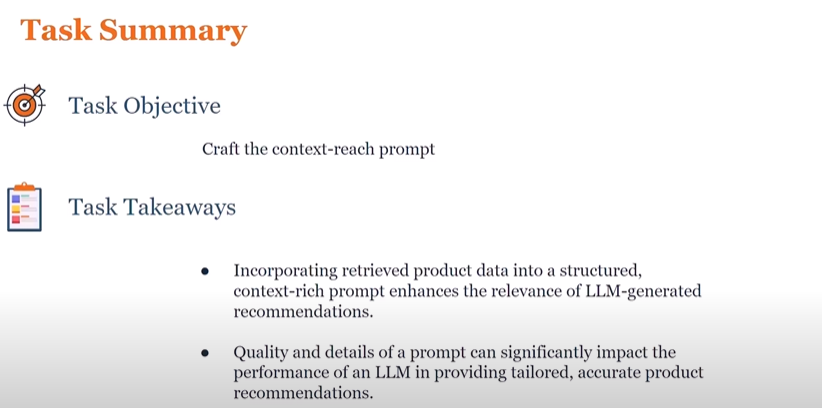

## Task 5 - Prompt the LLM to generate product recommendation

In this task, we will prompt the LLM using the context-rich prompt we created to generate user-friendly product recommendations based on the user's search phrase.

In [38]:
response = client.chat.completions.create(
    model = "gpt-4o",
    messages = [
        {
        "role": "user",
        "content": prompt
        }
    ],
    max_tokens = 1200
)
content = response.choices[0].message.content
print("User:", user_prompt)
print("Agent:", content)

User: I'm remodeling my bathroom and need a stylish white sink with a faucet included.
Agent: For your bathroom remodel, here are two stylish white sink options that come with faucets included:

1. **Modern in White Ceramic Rectangular Vessel Sink with Faucet Included with Overflow Drain Included**: This vessel sink features a rectangular shape and comes with an enamel glaze finish in white, providing a sleek and modern look. It's designed for an above-counter installation and includes a faucet as well as an overflow drain, making it a complete package for your bathroom needs.

2. **Porcelain Vessel Sink in Bisque with 718 Faucet and Pop-Up Drain in Chrome**: Although this sink is in a bisque color, it might still fit the stylish and sophisticated aesthetic you are looking for. It has a square format with gently tapered sides and a vitreous china coating that enhances its sanitary features. The included 718 faucet, constructed with solid-brass components, features a lead-free design an

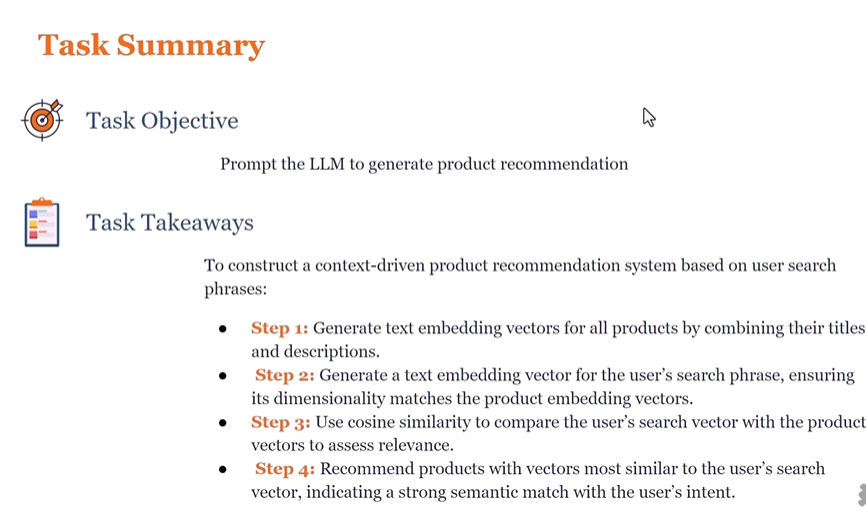